In [1]:
# Imports and plotting settings
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Ensure plots display inline
%matplotlib inline

# Output directory for saved files (adjust if needed)
OUT_DIR = "cognitive_dashboard_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Generate synthetic dataset
n = 200
student_id = np.arange(1, n+1)
names = [f"Student_{i:03d}" for i in student_id]
classes = np.random.choice(["A", "B", "C", "D"], size=n)

# Create correlated cognitive skill scores (0-100)
comprehension = np.clip(np.random.normal(70, 12, n) + np.random.normal(0, 5, n), 0, 100)
attention    = np.clip(np.random.normal(65, 15, n) + 0.3*(comprehension - 70), 0, 100)
focus        = np.clip(np.random.normal(60, 14, n) + 0.25*(attention - 65), 0, 100)
retention    = np.clip(np.random.normal(68, 13, n) + 0.2*(comprehension - 70), 0, 100)
engagement_time = np.clip(np.random.normal(45, 20, n) + 0.2*(focus - 60), 0, 180)

# Create assessment_score as weighted sum + noise
assessment_score = (
    0.30 * comprehension +
    0.25 * attention +
    0.20 * focus +
    0.15 * retention +
    0.10 * (engagement_time / 2.0)  # engagement_time has bigger unit, scale it
) + np.random.normal(0, 6, n)

assessment_score = np.clip(assessment_score, 0, 100)

# Build dataframe
df = pd.DataFrame({
    "student_id": student_id,
    "name": names,
    "class": classes,
    "comprehension": np.round(comprehension, 1),
    "attention": np.round(attention, 1),
    "focus": np.round(focus, 1),
    "retention": np.round(retention, 1),
    "engagement_time": np.round(engagement_time, 1),
    "assessment_score": np.round(assessment_score, 1)
})

# Save CSV
csv_path = os.path.join(OUT_DIR, "students_synthetic.csv")
df.to_csv(csv_path, index=False)

print("Dataset created:", csv_path)
df.head()

Dataset created: cognitive_dashboard_outputs\students_synthetic.csv


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score
0,1,Student_001,C,72.0,74.3,46.8,61.7,11.2,73.3
1,2,Student_002,D,63.4,67.7,85.2,69.6,41.5,67.9
2,3,Student_003,A,71.5,100.0,81.8,68.1,79.4,78.1
3,4,Student_004,C,44.2,74.1,80.1,78.3,66.0,61.0
4,5,Student_005,C,67.9,62.5,69.5,100.0,39.9,67.7


Shape: (200, 9)


,count,mean,std,min,25%,50%,75%,max
student_id,200.0,100.5000,57.879185,1.0,50.750,100.50,150.250,200.0
comprehension,200.0,70.2210,12.417695,27.6,62.475,70.20,77.850,100.0
attention,200.0,64.1400,15.324687,22.9,54.500,63.40,71.725,100.0
focus,200.0,60.5735,14.220028,30.2,51.500,59.65,69.850,100.0
retention,200.0,69.9235,12.762335,30.9,61.700,70.70,78.350,100.0
engagement_time,200.0,46.8515,20.706016,0.0,31.000,47.30,62.075,94.1
assessment_score,200.0,62.5585,10.223219,35.7,55.975,62.75,68.725,92.1



Class distribution:
class
C    54
D    54
A    46
B    46
Name: count, dtype: int64


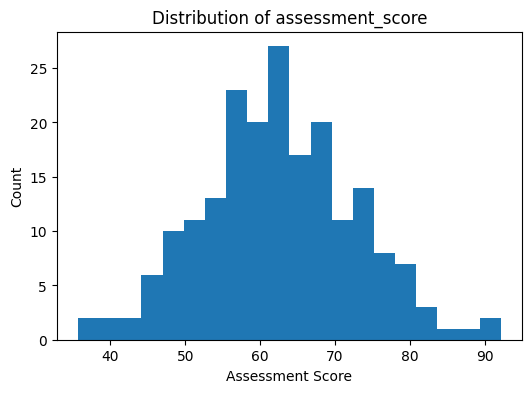

In [3]:
# Basic info
print("Shape:", df.shape)
display(df.describe().T)

# Value counts for classes
print("\nClass distribution:")
print(df['class'].value_counts())

# Histogram of assessment_score
plt.figure(figsize=(6,4))
plt.hist(df['assessment_score'], bins=20)
plt.title("Distribution of assessment_score")
plt.xlabel("Assessment Score")
plt.ylabel("Count")
plt.show()

,comprehension,attention,focus,retention,engagement_time,assessment_score
comprehension,1.000,0.132,-0.030,0.170,-0.028,0.502
attention,0.132,1.000,0.363,-0.004,0.038,0.612
focus,-0.030,0.363,1.000,0.133,0.173,0.462
retention,0.170,-0.004,0.133,1.000,0.120,0.277
engagement_time,-0.028,0.038,0.173,0.120,1.000,0.180
assessment_score,0.502,0.612,0.462,0.277,0.180,1.000


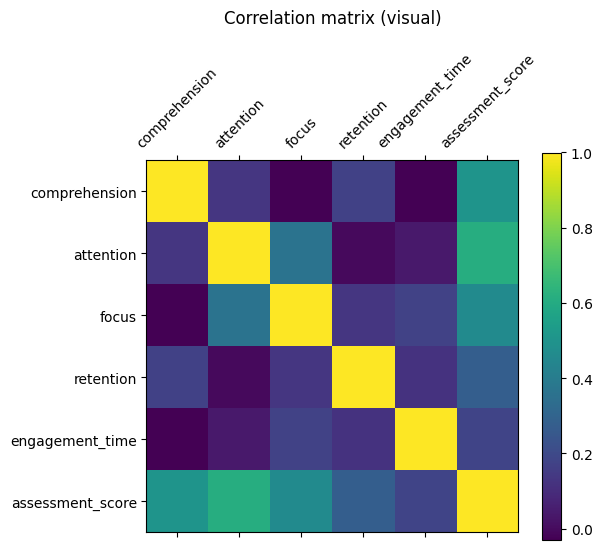

In [4]:
corr_cols = ["comprehension", "attention", "focus", "retention", "engagement_time", "assessment_score"]
corr = df[corr_cols].corr()
display(corr.round(3))

# Save correlation CSV
corr.to_csv(os.path.join(OUT_DIR, "correlations.csv"))

# Heatmap (matshow)
plt.figure(figsize=(6,5))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Correlation matrix (visual)", pad=20)
plt.show()

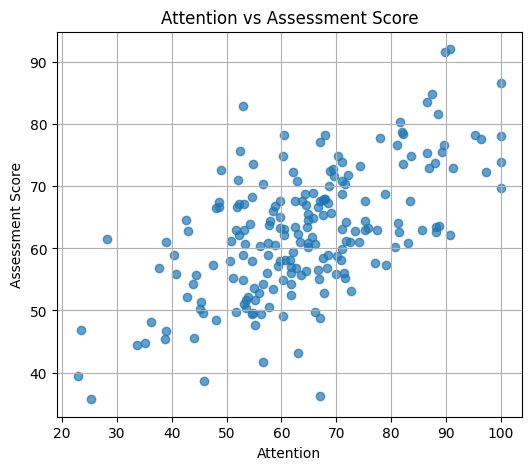

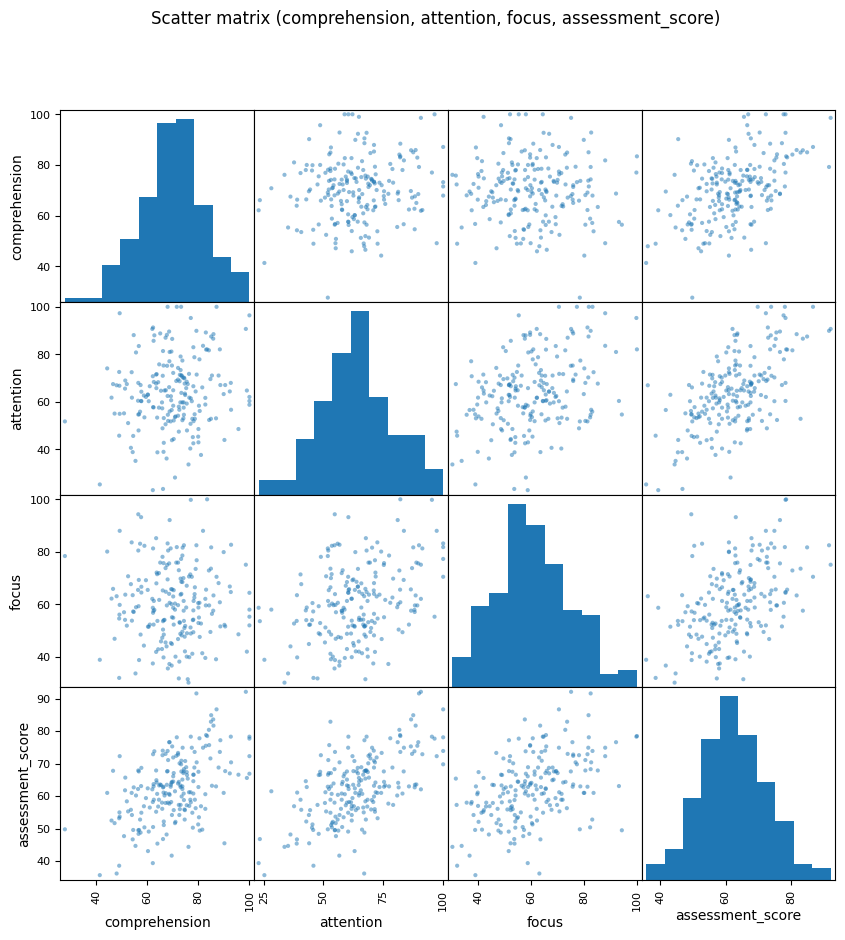

In [5]:
# Scatter: attention vs assessment_score
plt.figure(figsize=(6,5))
plt.scatter(df["attention"], df["assessment_score"], alpha=0.7)
plt.xlabel("Attention")
plt.ylabel("Assessment Score")
plt.title("Attention vs Assessment Score")
plt.grid(True)
plt.show()

# Scatter matrix for a subset (optional)
pd.plotting.scatter_matrix(df[["comprehension","attention","focus","assessment_score"]], figsize=(10,10))
plt.suptitle("Scatter matrix (comprehension, attention, focus, assessment_score)")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
import pandas as pd
import os

# Features & target
X = df[["comprehension", "attention", "focus", "retention", "engagement_time"]]
y = df["assessment_score"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Feature importances from RF
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print results
print("Linear Regression -> RMSE: {:.3f}, R2: {:.3f}".format(rmse_lr, r2_lr))
print("Random Forest     -> RMSE: {:.3f}, R2: {:.3f}".format(rmse_rf, r2_rf))

print("\nFeature importances (Random Forest):")
display(feat_imp)

# Save feature importances
feat_imp.to_csv(os.path.join(OUT_DIR, "feature_importances.csv"))

Linear Regression -> RMSE: 6.651, R2: 0.560
Random Forest     -> RMSE: 7.203, R2: 0.484

Feature importances (Random Forest):


attention          0.396623
comprehension      0.270570
focus              0.161680
retention          0.115527
engagement_time    0.055601
dtype: float64

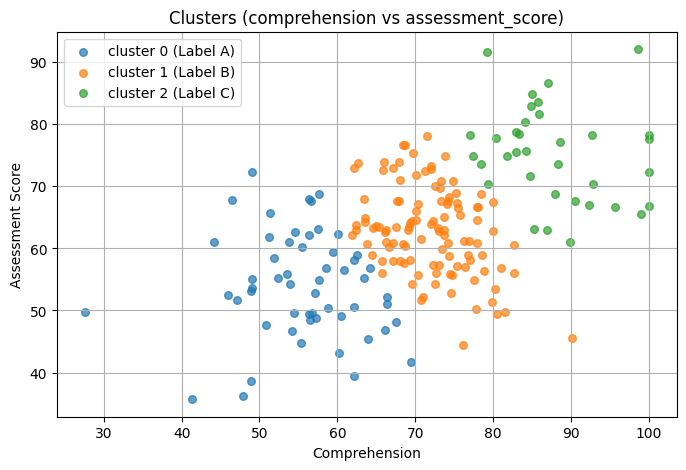

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Perform KMeans clustering with 3 clusters (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=RANDOM_SEED)
df['cluster'] = kmeans.fit_predict(df[["comprehension", "assessment_score"]])

# Optional: Define persona labels for each cluster if you have them
persona_labels = {
    'persona_0': 'Label A',
    'persona_1': 'Label B',
    'persona_2': 'Label C'
}

# Plot cluster scatter (comprehension vs assessment_score) colored by cluster
plt.figure(figsize=(8,5))
for c in sorted(df["cluster"].unique()):
    sub = df[df["cluster"] == c]
    plt.scatter(sub["comprehension"], sub["assessment_score"],
                label=f"cluster {c} ({persona_labels.get('persona_'+str(c), '')})", s=30, alpha=0.7)

plt.xlabel("Comprehension")
plt.ylabel("Assessment Score")
plt.title("Clusters (comprehension vs assessment_score)")
plt.legend()
plt.grid(True)
plt.show()

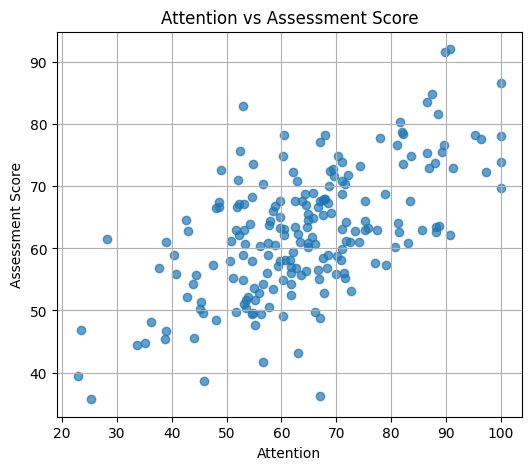

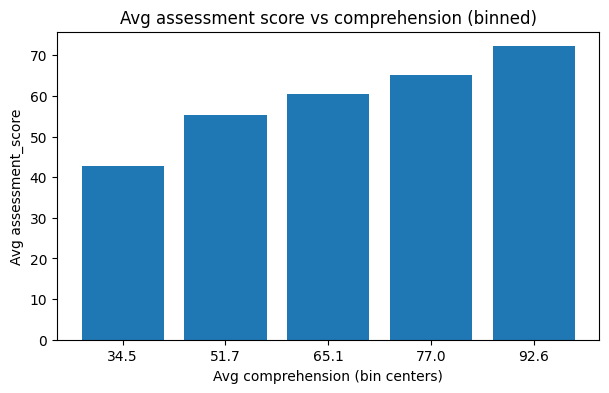

In [11]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Save scatter: attention vs assessment_score
plt.figure(figsize=(6,5))
plt.scatter(df["attention"], df["assessment_score"], alpha=0.7)
plt.xlabel("Attention")
plt.ylabel("Assessment Score")
plt.title("Attention vs Assessment Score")
plt.grid(True)
scatter_path = os.path.join(OUT_DIR, "scatter_attention_vs_score.png")
plt.savefig(scatter_path, bbox_inches="tight")
plt.show()

# Save bar: avg assessment vs binned comprehension
df["comp_bin"] = pd.cut(df["comprehension"], bins=5)
avg_by_bin = df.groupby("comp_bin", observed=True).agg({
    "assessment_score": "mean",
    "comprehension": "mean"
}).reset_index()

plt.figure(figsize=(7,4))
plt.bar(range(len(avg_by_bin)), avg_by_bin["assessment_score"])
plt.xticks(range(len(avg_by_bin)), [f"{round(v, 1)}" for v in avg_by_bin["comprehension"]])
plt.ylabel("Avg assessment_score")
plt.xlabel("Avg comprehension (bin centers)")
plt.title("Avg assessment score vs comprehension (binned)")
bar_path = os.path.join(OUT_DIR, "bar_skill_vs_score.png")
plt.savefig(bar_path, bbox_inches="tight")
plt.show()

In [12]:
print("Files saved to:", OUT_DIR)
print("Top model metrics:")
print("  Linear Regression -> RMSE: {:.3f}, R2: {:.3f}".format(rmse_lr, r2_lr))
print("  Random Forest     -> RMSE: {:.3f}, R2: {:.3f}".format(rmse_rf, r2_rf))
print("\nTop features (RF):")
print(feat_imp.round(3))
print("\nPersona labels (heuristic):")
print(json.dumps(persona_labels, indent=2))

# show first 6 rows of df with cluster
display(df.head(6))

Files saved to: cognitive_dashboard_outputs
Top model metrics:
  Linear Regression -> RMSE: 6.651, R2: 0.560
  Random Forest     -> RMSE: 7.203, R2: 0.484

Top features (RF):
attention          0.397
comprehension      0.271
focus              0.162
retention          0.116
engagement_time    0.056
dtype: float64

Persona labels (heuristic):
{
  "persona_0": "Label A",
  "persona_1": "Label B",
  "persona_2": "Label C"
}


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score,cluster,comp_bin
0,1,Student_001,C,72.0,74.3,46.8,61.7,11.2,73.3,1,"(71.04, 85.52]"
1,2,Student_002,D,63.4,67.7,85.2,69.6,41.5,67.9,1,"(56.56, 71.04]"
2,3,Student_003,A,71.5,100.0,81.8,68.1,79.4,78.1,1,"(71.04, 85.52]"
3,4,Student_004,C,44.2,74.1,80.1,78.3,66.0,61.0,0,"(42.08, 56.56]"
4,5,Student_005,C,67.9,62.5,69.5,100.0,39.9,67.7,1,"(56.56, 71.04]"
5,6,Student_006,D,77.6,52.9,41.2,62.6,34.3,54.9,1,"(71.04, 85.52]"
